In [1]:
%pylab inline
import octopus
from pygadgetreader import readsnap
import biff
from astropy import units as u
from astropy import constants

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/ngaravito/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


Populating the interactive namespace from numpy and matplotlib


# To do: 

1. Do this with a HR halo.
2. Lower the number of particles to a few tens to really understand what is going on.
3. Find which terms really appear.
4. Check the high order terms with my code.
5. Check the potential change due to the number of coefficients.

In [23]:
def re_center(pos, cm):
    """
    Re center a halo to its center of mass.
    """
    for i in range(3):
        pos[:,i] = pos[:,i] - cm[i]
    return pos

def biff_potential(pos, S, T, n,l,m):
    S_new = np.zeros(shape(S))
    T_new = np.zeros(shape(T))
    S_new[n,l,m] = S[n,l,m]
    T_new[n,l,m] = T[n,l,m]
    pot_nlm = biff.potential(pos.astype(double), S_new, T_new, G=G_c.value, M=1, r_s=3)
    #r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    #indexes = argsort(r)
    return pot_nlm
    
def n_body_potential(pos, pot):
    r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    indexes = argsort(r)
    return r[indexes], pot[indexes]

In [146]:
def high_order_terms(Coeff):
    """
    Identify the indices (n,l,m) of the terms which amplitude is larger than 
    the (n=0, l=0, m=0) term.
    Input:
    ------
        Coeff : float
            A 3d matrix of the coefficients.
    
    Output:
    -------
        n : list
           List with the ``n`` indices.
        l : list
           List with the ``l`` indices.
        m : list
           List with the ``m`` indices.
    """
    
    index = np.where(Coeff>Coeff[0,0,0])
    n = index[0]
    l = index[1]
    m = index[2]
    
    #print('n=', n)
    #print('l=', l)
    #print('m=', m)
    coeffs = np.array([n, l, m, Coeff[n,l,m]]).T
    return coeffs[coeffs[:,3].argsort()]


def pot_diff(pot1, pot2):
    dif = np.abs(np.abs(pot1)-np.abs(pot2))
    return dif

# Potential comparisson from the N body to the analytic and the SCF method

In [653]:
# Computing the center of mass of the halo.
pos_cm_LMC, vel_cm_LMC, a, b = octopus.orbit('../../data/ICs/LMC/LMC1-97k/', 'LMC1_97K_vir', 0, 100, 97000, 0.1)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    

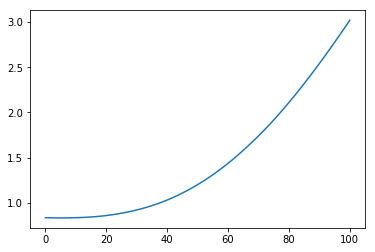

In [654]:
# CM trajectory.
rcm_LMC = np.sqrt(pos_cm_LMC[:,0]**2 + pos_cm_LMC[:,1]**2 + pos_cm_LMC[:,2]**2)
plot(rcm_LMC)

In [194]:
# Fisrt snapshot properties!
pos_LMC = readsnap('../../data/ICs/LMC/LMC6_20M_vir_000', 'pos', 'dm')
vel_LMC = readsnap('../../data/ICs/LMC/LMC6_20M_vir_000', 'vel', 'dm')
mass_LMC = readsnap('../../data/ICs/LMC/LMC6_20M_vir_000', 'mass', 'dm')
pid_LMC = readsnap('../../data/ICs/LMC/LMC6_20M_vir_000', 'pid', 'dm')
pot_LMC = readsnap('../../data/ICs/LMC/LMC6_20M_vir_000', 'pot', 'dm')

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Particle IDs
Returning DM    Potential


In [ ]:
# Computing all the coefficients for the first snapshot
S0, T0 = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC.astype(double)), mass_LMC.astype(double)*1E10, 10, 10, 3)

Remeber to correct by the fact that Gagdet have different units for G
this is:
$G=43007.1$

In [6]:
G_c = constants.G
G_c = G_c.to(u.kiloparsec**3 / (u.s**2 * u.Msun)) # 
pot_factor = G_c/43007.1 *1E10

In [7]:
r_lmc, pot_nb_lmc = n_body_potential(pos_LMC, pot_LMC)

In [8]:
# Analytic potential
pot_an_lmc = octopus.pot_hernquist(3, r_lmc, 3E10)
# Biff potential
pot_biff_LMC = biff.potential(pos_LMC.astype(double), S0, T0, G=G_c.value, M=1, r_s=3)

In [9]:
r = np.sqrt(pos_LMC[:,0]**2 + pos_LMC[:,1]**2 + pos_LMC[:,2]**2)
indexes = argsort(r)


(0.009968961589038372, 100)

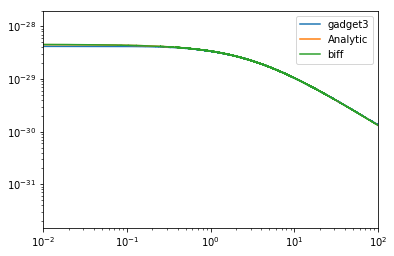

In [10]:
loglog(r_lmc, np.abs(pot_nb_lmc)*pot_factor, label='gadget3')
loglog(r_lmc, np.abs(pot_an_lmc), label='Analytic')
loglog(r[indexes], np.abs(pot_biff_LMC[indexes]), label='biff')
legend()
xlim(0, 100)

In [22]:
## Finding high order terms! 
hot_S0 = high_order_terms(S0)
print(hot_S0.astype(float32))

[[  1.00000000e+00   1.00000000e+01   9.00000000e+00   3.29664471e+10]
 [  0.00000000e+00   7.00000000e+00   7.00000000e+00   4.12068946e+10]
 [  1.00000000e+00   8.00000000e+00   3.00000000e+00   5.16889190e+10]
 [  0.00000000e+00   7.00000000e+00   3.00000000e+00   5.23610522e+10]
 [  0.00000000e+00   7.00000000e+00   5.00000000e+00   5.30872648e+10]
 [  0.00000000e+00   8.00000000e+00   2.00000000e+00   9.01544182e+10]
 [  1.00000000e+00   9.00000000e+00   2.00000000e+00   9.42397276e+10]
 [  1.00000000e+00   1.00000000e+01   2.00000000e+00   1.21613894e+11]
 [  0.00000000e+00   9.00000000e+00   5.00000000e+00   1.32432912e+11]
 [  1.00000000e+00   9.00000000e+00   8.00000000e+00   1.32493722e+11]
 [  1.00000000e+00   1.00000000e+01   8.00000000e+00   1.63005301e+11]
 [  0.00000000e+00   9.00000000e+00   9.00000000e+00   1.81948187e+11]
 [  0.00000000e+00   8.00000000e+00   3.00000000e+00   2.03341627e+11]
 [  1.00000000e+00   1.00000000e+01   1.00000000e+01   2.27677798e+11]
 [  0.

In [30]:
def grid_gen(xmin, xmax, ymin, ymax, zmin, zmax, n_spaces):
    """
    n_spaces : int
        space between points.
    """
    X, Y, Z = np.mgrid[xmin:xmax:n_spaces, ymin:ymax:n_spaces, zmin:zmax:n_spaces]
    cart_grid = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
    return cart_grid
    #figure(figsize=(5,5))
    #scatter(cart_grid[0], cart_grid[1], s=0.1)

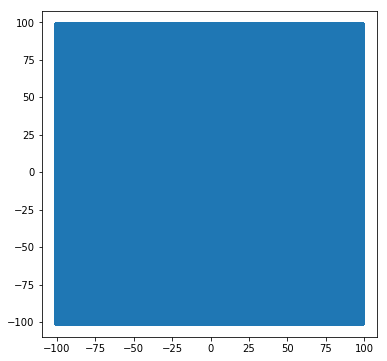

In [165]:
# Example of the grid
figure(figsize=(6,6))
grid_pos = grid_gen(-100, 100, -100, 100, -100, 100, 3)
scatter(grid_pos[0], grid_pos[1])

In [166]:
pot_biff_all_LMC = biff.potential(ascontiguousarray(grid_pos.T.astype(double)), S0, T0, G=G_c.value, M=1, r_s=3)
pot_biff_partial_LMC = biff_potential(ascontiguousarray(grid_pos.T), S0, T0, 0, 10, 9)
pot_biff_principal_LMC = biff_potential(ascontiguousarray(grid_pos.T), S0, T0, 0, 0, 0)

#pot_biff_partial_LMC

In [ ]:
### computing differences in the potential!

In [183]:
pot_dif_all_all = pot_diff(pot_biff_all_LMC, pot_biff_all_LMC)
print(sum(pot_dif_all_all))

0.0


In [184]:
pot_dif_all_principal = pot_diff(pot_biff_all_LMC, pot_biff_principal_LMC)
print(sum(pot_dif_all_principal))

3.0990312109e-28


In [185]:
pot_dif_all_partial = pot_diff(pot_biff_all_LMC, pot_biff_partial_LMC)
print(sum(pot_dif_all_partial))

4.61786903561e-25


In [186]:
def scatter_slice(pos, pot, zmin, zmax):
    """
    Slices the 3d cartessian grid along the z-coordinate.
    
    """
    index = np.where((pos[:,2]<zmax) & ((pos[:,2]>zmin)))
    return pos[index], pot[index]
    

In [ ]:
### Visualizing the potential 

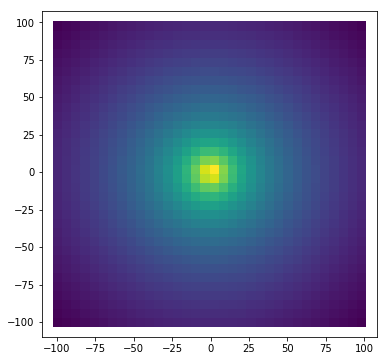

In [131]:
figure(figsize=(6,6))
pos_slice, pot_slice_all = scatter_slice(grid_pos.T, pot_biff_all_LMC, -5, 5)
scatter(pos_slice[:,0], pos_slice[:,1], c = np.log10(np.abs(pot_slice_all)/np.max(np.abs(pot_biff_all_LMC))), s=70, marker='s')

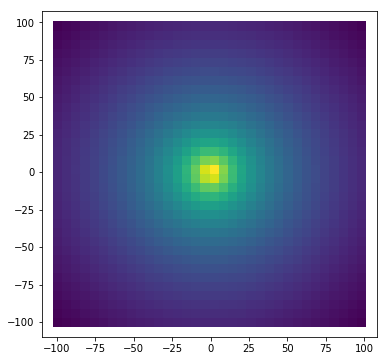

In [132]:
figure(figsize=(6,6))
pos_slice, pot_slice_principal = scatter_slice(grid_pos.T, pot_biff_principal_LMC, -5, 5)
scatter(pos_slice[:,0], pos_slice[:,1], c = np.log10(np.abs(pot_slice_principal)/np.max(np.abs(pot_biff_all_LMC))), s=70, marker='s')

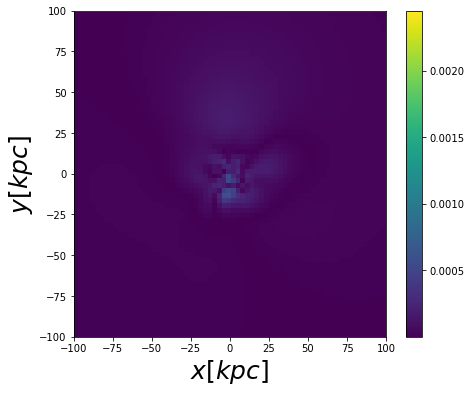

In [191]:
figure(figsize=(7,6))
pos_slice, pot_slice_dif_all_principal = scatter_slice(grid_pos.T, pot_dif_all_principal, 0, 10)
scatter(pos_slice[:,0], pos_slice[:,1], c = (np.abs(pot_slice_dif_all_principal)/np.max(np.abs(pot_biff_all_LMC)))
        ,s=17, marker='s')
xlabel('$x[kpc]$', fontsize=25)
ylabel('$y[kpc]$', fontsize=25)
xlim(-100,100)
ylim(-100,100)

colorbar()

In [ ]:
figure(figsize=(7,6))
pos_slice, pot_slice_partial = scatter_slice(grid_pos.T, pot_biff_partial_LMC, -25, -20)
scatter(pos_slice[:,0], pos_slice[:,1], c = np.log10(np.abs(pot_slice_partial)/np.max(np.abs(pot_biff_partial_LMC)))
        ,s=80, marker='s')
xlabel('$x[kpc]$', fontsize=25)
ylabel('$y[kpc]$', fontsize=25)
xlim(-100,100)
ylim(-100,100)

colorbar()

# Relaxation effect!

Does the relaxation have any inprint in the amplitude of the coefficients?


In [117]:
pos_LMC_f = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_100', 'pos', 'dm')
vel_LMC_f = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_100', 'vel', 'dm')
mass_LMC_f = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_100', 'mass', 'dm')
pid_LMC_f = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_100', 'pid', 'dm')

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Particle IDs


In [119]:
pos_LMC_centered = re_center(pos_LMC, pos_cm_LMC[0])
pos_LMC_f_centered = re_center(pos_LMC_f, pos_cm_LMC[100])
#octopus.CM(pos_LMC_centered,  vel_LMC)
S0_cm, T0_cm = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_centered.astype(double)), mass_LMC.astype(double), 10, 10, 3)
S0f_cm, T0f_cm = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_f_centered.astype(double)), mass_LMC.astype(double), 10, 10, 3)

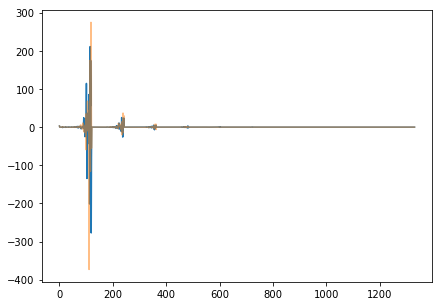

In [148]:
figure(figsize=(7,5))
plot(S0_cm.flatten(), alpha=1)
plot(S0f_cm.flatten(), alpha=0.5)

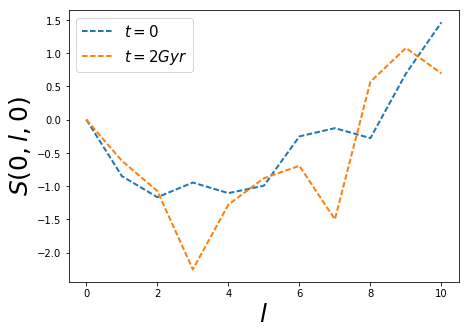

In [147]:
figure(figsize=(7,5))

plot(np.log10(np.abs(S0_cm[0,:,0])/np.abs(S0_cm[0,0,0])), lw=2, ls='--', label='$t=0$')
plot(np.log10(np.abs(S0f_cm[0,:,0])/np.abs(S0f_cm[0,0,0])), lw=2, ls='--', label='$t=2Gyr$')
legend(fontsize=15)
xlabel('$l$', fontsize=25)
ylabel('$S(0, l, 0)$', fontsize=25)

## Off center effect on the BFE expansion

In [150]:
pos_LMC_off_center = re_center(pos_LMC, [5, 5, 5])
S0_off, T0_off = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_off_center.astype(double)), mass_LMC.astype(double), 10, 10, 3)


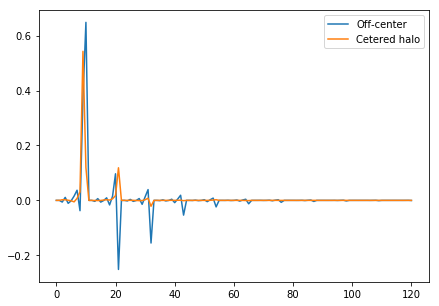

In [176]:
figure(figsize=(7,5))
plot(S0_off[:,:,2].flatten()/np.abs(np.max(S0_off)), alpha=1, label='Off-center')
plot(S0_cm[:,:,2].flatten()/np.abs(np.max(S0_cm)), alpha=1, label='Cetered halo')
legend()

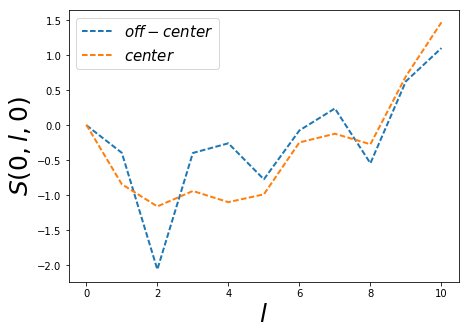

In [173]:
figure(figsize=(7,5))

plot(np.log10(np.abs(S0_off[0,:,0])/np.abs(S0_off[0,0,0])), lw=2, ls='--', label='$off-center$')
plot(np.log10(np.abs(S0_cm[0,:,0])/np.abs(S0f_cm[0,0,0])), lw=2, ls='--', label='$center$')
legend(fontsize=15)
xlabel('$l$', fontsize=25)
ylabel('$S(0, l, 0)$', fontsize=25)

## conclusion: There is effect due to the CM ! 

# truncation radii on the BFE expansion coefficients

In [9]:
def trunc_radii(pos,  r_t):
    pos_r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2) 
    len(pos_r)
    index = np.where(pos_r < r_t)
    return pos[index]

In [10]:
pos_LMC_trunc = trunc_radii(pos_LMC_centered, 10)

In [11]:
S0_tr, T0_tr = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_trunc.astype(double)), mass_LMC.astype(double), 10, 10, 3)

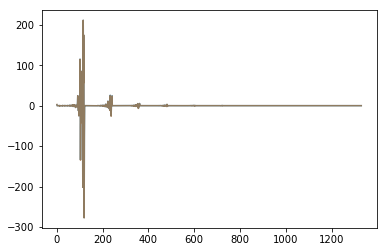

In [162]:
plot(S0_tr.flatten(), alpha=1)
plot(S0_cm.flatten(), alpha=0.5)


## conclusion: Not much effect due to the truncation radii

In [189]:
def random_res_damping(pids, pos, M, damp_perc):
    """
    Decrease the resolution of a halo by randomly selecting
    particle ids.
    
    Parameters:
    -----------
        pids : array
           1-d array with the halo particle ids.
        damp_perc : int
            percetange to decrease the halo resolution, range: [0-100].
    
    Returns:
    --------
         pids :  array
             1-d array with the randomly selected halo particle ids.
    """
    N = len(pids)
    assert((damp_perc>=0) & (damp_perc<100))
    N_indixes = int(N-N*damp_perc/100.)
    print(N_indixes)
    random_indexes = np.random.randint(0, N, N_indixes)
    return pids[random_indexes], pos[random_indexes], M[random_indexes]
    
    

In [190]:
scatter(pos_lr_LMC[:,0], pos_lr_LMC[:,1], s=0.1)
xlim(-100, 100)
ylim(-100, 100)

NameError: name 'pos_lr_LMC' is not defined

97000
33
48500
31
9700
41
970
61
97
77


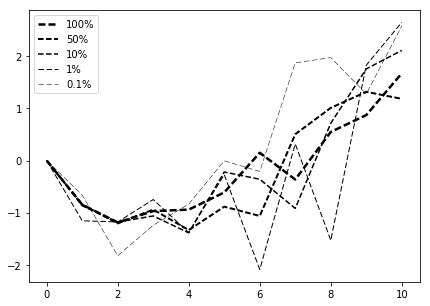

In [116]:
figure(figsize=(7,5))
resolutions = [0, 50, 90, 99, 99.9 ]
labels = ['100%', '50%', '10%', '1%', '0.1%']
for i in range(len(resolutions)):
    pids_lr_LMC, pos_lr_LMC, mass_lr_LMC = random_res_damping(pid_LMC, pos_LMC_centered, mass_LMC, resolutions[i])
    S0_lr1, T0_lr1 = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_lr_LMC.astype(double)), mass_LMC.astype(double), 10, 10, 3)
    coeffs = high_order_terms(S0_lr1)
    print(shape(coeffs)[1])
    plot(np.log10(np.abs(S0_lr1[0,:,0])/np.abs(S0_lr1[0,0,0])), c='k', lw=2.5-i/2.0, ls='--', label=labels[i])
    plt.legend(loc='best')
